In [1]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
from torchvision import transforms
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models.detection.backbone_utils as backbone_utils
import torchvision.models.resnet as resnet
import torchvision.models._utils as _utils
import torchvision.transforms.functional as tf
import torch.nn.functional as F
from numpy.random import uniform
from PIL import Image, ImageDraw
from collections import OrderedDict
from random import shuffle
import torchvision.ops as ops
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os.path as osp
import numpy as np
import time
import math
import random
import argparse
import os
import copy
import json
from torch.utils.data.sampler import Sampler
from skimage.util import crop
import skimage.transform
from scipy import misc
import skimage.color
import skimage.io
import skimage
import cv2
import warnings
warnings.filterwarnings("ignore")

### Dataset

In [2]:
def readLmk(fileName):
    landmarks = []
    if not os.path.exists(fileName):
        return landmarks
    else:
        fp = open(fileName)
        i = 0
        for line in fp.readlines():
            TT = line.strip("\n")
            if i>2 and i<71:
                # print TT
                TT_temp = TT.split(" ")
                x = float(TT_temp[0])
                y = float(TT_temp[1].strip("\r"))
                landmarks.append((x,y))
            i += 1
    return np.array(landmarks)

In [3]:
class RandomErasing(object):
    def __init__(self,p=0.3):
        self.p=p
    def __call__(self, sample):
            if(np.random.rand()<self.p):
                image, annots = np.array(sample['img']), np.array(sample['annot'][0])
                box1,box2,box3,box4=int(annots[0]),int(annots[1]),int(annots[2]),int(annots[3])
                randx1=random.randint(box1-3,box3-3)
                randx2=random.randint(box1-3,box3-3)
                randy1=random.randint(box2-3,box4-3)
                randy2=random.randint(box2-3,box4-3)
                x1=min(randx1,randx2)
                x2=max(randx1,randx2)
                y1=min(randy1,randy2)
                y2=max(randy1,randy2)
                for y in range(y1,y2):
                    for x in range(x1,x2):
                        try:
                            image[x][y]=[0,0,0]
                        except:
                            return sample
                return {'img': torch.tensor(image), 'annot': torch.tensor(annots[np.newaxis,:])}
            return sample

class Color(object):
    def __call__(self,sample):
        img = np.array(sample['img'])
        img=Image.fromarray(img.astype('uint8'))
        img=transforms.ColorJitter()(img)
        img=np.array(img)
        return {'img': torch.tensor(img), 'annot': sample['annot']}

In [4]:
class Resizer(object):
    def __init__(self,input_size=640):
        if input_size==None:
            self.input_size=None
        else:
            self.input_size=input_size
    def __call__(self, sample):
        image, annots = np.array(sample['img']), sample['annot']
        if self.input_size==None:
            if random.random()<0.4:
                input_size=random.randint(250,640)
            else:
                input_size=640
        else:
            input_size=self.input_size
        rows, cols, _ = image.shape
        long_side = max(rows, cols)
        scale = input_size / long_side

        # resize image
        resized_image = skimage.transform.resize(image,(int(rows*input_size / long_side),int(cols*input_size / long_side)))
        resized_image = resized_image * 255
        
        assert (resized_image.shape[0]==input_size or resized_image.shape[1]==input_size), 'resized image size not {}'.format(input_size)

        if annots.shape[1] > 4 :
            annots = annots * scale
        else :
            annots[:,:4] = annots[:,:4] * scale
        
        return {'img': torch.tensor(resized_image), 'annot': annots}
    


class PadToSquare(object):
    def __call__(self, sample, input_size=640):    
        image, annots = sample['img'], sample['annot']
        rows, cols, _ = image.shape
        dim_diff = np.abs(rows - cols)

        # relocate bbox annotations
        if rows == input_size:
            diff = input_size - cols
            annots[:,0] = annots[:,0] + diff/2
            annots[:,2] = annots[:,2] + diff/2
        elif cols == input_size:
            diff = input_size - rows
            annots[:,1] = annots[:,1] + diff/2
            annots[:,3] = annots[:,3] + diff/2
        if annots.shape[1] > 4 :
            ldm_mask = annots[:,4] > 0
            if rows == input_size:
                diff = input_size - cols
                annots[ldm_mask,4::2] = annots[ldm_mask,4::2] + diff/2
            elif cols == input_size:
                diff = input_size - rows
                annots[ldm_mask,5::2] = annots[ldm_mask,5::2] + diff/2

        # pad image to square
        img = image
        img = img.permute(2,0,1)
        pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
        pad = (0, 0, pad1, pad2) if rows <= cols else (pad1, pad2, 0, 0)

        padded_img = F.pad(img, pad, "constant", value=0)
        
        # pad to input size
        pad_=input_size-padded_img.shape[1]
        num1= random.randint(0,pad_)
        num2= random.randint(0,pad_)
        
        pading = (num1, pad_-num1,num2,pad_-num2)
        padded_img = F.pad(padded_img, pading, "constant", value=0)
        for i in range(0,140):
            if i%2==0:
                annots[0,i]+=num1
            else:
                annots[0,i]+=num2
        padded_img = padded_img.permute(1,2,0)

        return {'img': padded_img, 'annot': annots}

In [5]:
class Rotate(object):
    def __init__(self,angle=[-45,45],p=1):
        self.angle=angle
        self.p=p
    def __call__(self,sample):
        if(np.random.rand()<self.p):
            img=np.array(sample['img'])
            h,w,c=img.shape
            annots=sample['annot']
            center = (w//2, h//2)
            random_degree=random.randint(self.angle[0],self.angle[1])
            
            rot_mat = cv2.getRotationMatrix2D(center, random_degree, 1)
            img_rotated_by_alpha = cv2.warpAffine(img, rot_mat, (w, h))
           
            box=np.array(annots)[0]
            minx=float('inf')
            miny=float('inf')
            maxx=0
            maxy=0
            for i in range(4,140):
                if(i%2==0):
                    x=box[i]
                    y=box[i+1]
                    box[i]=rot_mat[0][0]*x+rot_mat[0][1]*y+rot_mat[0][2]
                    box[i+1]=rot_mat[1][0]*x+rot_mat[1][1]*y+rot_mat[1][2]
                    
                    
                    if(box[i]<minx):
                        minx=box[i]
                    if(box[i]>maxx):
                        maxx=box[i]
                    if(box[i+1]<miny):
                        miny=box[i+1]
                    if(box[i+1]>maxy):
                        maxy=box[i+1]

            box[0] = minx -int((maxx-minx)/10)                # x1
            box[1] = miny -int((maxy-miny)/10)               # y1
            box[2] = maxx +int((maxx-minx)/10)   
            box[3] = maxy  +int((maxy-miny)/10)  

            return {'img': torch.tensor(img_rotated_by_alpha), 'annot': torch.tensor(box[np.newaxis,:])}
        return sample

In [6]:
class RandomFlip(object):
    def __call__(self, sample, input_size=320, flip_x=1):
        aaa=np.random.rand()
        if aaa < flip_x:
            image, annots = sample['img'], sample['annot']
            h,w,c=image.shape
            # flip image
            image = torch.flip(image,[1])
            annots = annots.numpy()
           
            #relocate bboxes
            for i in range(0,140):
                if i%2==0:
                    annots[0, i] = w - annots[0, i]

            annots = torch.from_numpy(annots)

            sample = {'img': image, 'annot': annots}

        return sample

In [7]:
def collater(data):
    batch_size = len(data)

    imgs = [s['img'] for s in data]
    annots = [s['annot'] for s in data]

    # batch images
    height = imgs[0].shape[0]
    width = imgs[0].shape[1]
    assert height==width ,'Input width must eqs height'

    input_size = width
    batched_imgs = torch.zeros(batch_size, height, width, 3)

    for i in range(batch_size):
        img = imgs[i]
        batched_imgs[i,:] = img

    # batch annotations
    max_num_annots = max(annot.shape[0] for annot in annots)
    
    if max_num_annots > 0:
        if annots[0].shape[1] > 4:
            annot_padded = torch.ones((len(annots), max_num_annots, 140)) * -1
            for idx, annot in enumerate(annots):
                if annot.shape[0] > 0:
                    annot_padded[idx, :annot.shape[0], :] = annot
        else:
            annot_padded = torch.ones((len(annots), max_num_annots, 4)) * -1
            for idx, annot in enumerate(annots):
                if annot.shape[0] > 0:
                    annot_padded[idx, :annot.shape[0], :] = annot
    else:
        if annots[0].shape[1] > 4:
            annot_padded = torch.ones((len(annots), 1, 140)) * -1
        else:
            annot_padded = torch.ones((len(annots), 1, 4)) * -1

    batched_imgs = batched_imgs.permute(0, 3, 1, 2)

    return {'img': batched_imgs, 'annot': annot_padded}

In [8]:
class CustimizedDataset(Dataset):
    
    def __init__(self, phase, file_path=None,transform=None,flip=False):   
        self.phase = phase
        self.files=[]
        for i in os.listdir(file_path):
            file_name=i[:-4]
            if file_name not in self.files:
                self.files.append(file_name)
        self.transform = transform
        self.flip = flip
        self.batch_count = 0
        self.img_size = 640
        self.init_all_data(file_path) 
        return None
        

    def init_all_data(self, file_path):
        self.images = []
        self.datas = []

        suffix1 = ".jpg"

        suffix2 = '.png'
        for file_name in self.files:
            file_name = os.path.join(file_path, file_name)
          
            img1 = file_name+suffix1
            if self.is_valid_image(img1):
                self.images.append(img1)
                self.datas.append(file_name+".pts")
            img2 = file_name+suffix2
            if self.is_valid_image(img2):
                self.images.append(img2)
                self.datas.append(file_name+".pts")
        return None

        
    def is_valid_image(self, img_path):
        try:
            i = Image.open(img_path)
            valid = True
        except:
            valid = False
            
        return valid
        

    def __getitem__(self, idx):
        img = cv2.imread(self.images[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        annotations = np.zeros((0, 4+136))#4 +68*2
        annotation = np.zeros((1,140))
        landmark=[]
        minx=float('inf')
        miny=float('inf')
        maxx=0
        maxy=0
        ptsFile=self.datas[idx]
        data = readLmk(ptsFile)
        for da in data:
            if(da[0]<minx):
                minx=da[0]
            if(da[0]>maxx):
                maxx=da[0]
            if(da[1]<miny):
                miny=da[1]
            if(da[1]>maxy):
                maxy=da[1]
            landmark.append(da[0])
            landmark.append(da[1])
        # bbox
        annotation[0,0] = minx -int((maxx-minx)/10)                # x1
        annotation[0,1] = miny -int((maxy-miny)/10)               # y1
        annotation[0,2] = maxx +int((maxx-minx)/10)   
        annotation[0,3] = maxy +int((maxy-miny)/10)   

        for i in range(4,140):
            annotation[0,i] = landmark[i-4]
        annotations = np.append(annotations,annotation,axis=0)        
        
        sample = {'img':torch.tensor(img), 'annot':torch.tensor(annotations)}
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample

    def __len__(self):
        if self.phase=='test':
            return 16
#         return 20
        return len(self.images)

### Model

In [9]:
class mobileV1(nn.Module):
    def __init__(self):
        super(mobileV1, self).__init__()
            
        self.mobilenet0_conv0 = nn.Sequential(
                    nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1, bias=False),
                    nn.BatchNorm2d(num_features=8, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv1 = nn.Sequential(
                    nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1, groups=8, bias=False),
                    nn.BatchNorm2d(num_features=8, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv2 = nn.Sequential(
                    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=16, momentum=0.9),
                    nn.ReLU(inplace=True))
        
        self.mobilenet0_conv3 = nn.Sequential(
                    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=2, padding=1, groups=16, bias=False),
                    nn.BatchNorm2d(num_features=16, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv4 = nn.Sequential(
                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=32, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv5 = nn.Sequential(
                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, groups=32, bias=False),
                    nn.BatchNorm2d(num_features=32, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv6 = nn.Sequential(
                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=32, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv7 = nn.Sequential(
                    nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1, groups=32, bias=False),
                    nn.BatchNorm2d(num_features=32, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv8 = nn.Sequential(
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=64, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv9 = nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, groups=64, bias=False),
                    nn.BatchNorm2d(num_features=64, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv10 = nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=64, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv11 = nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, groups=64, bias=False),
                    nn.BatchNorm2d(num_features=64, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv12 = nn.Sequential(
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv13 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, groups=128, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv14 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv15 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, groups=128, bias=False),
                    nn.BatchNorm2d(num_features=128),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv16 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))
        
        self.mobilenet0_conv17 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, groups=128, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))
        
        self.mobilenet0_conv18 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv19 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, groups=128, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv20 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv21 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, groups=128, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv22 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv23 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, groups=128, bias=False),
                    nn.BatchNorm2d(num_features=128, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv24 = nn.Sequential(
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=256, momentum=0.9),
                    nn.ReLU(inplace=True))
        
        self.mobilenet0_conv25 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, groups=256, bias=False),
                    nn.BatchNorm2d(num_features=256, momentum=0.9),
                    nn.ReLU(inplace=True))

        self.mobilenet0_conv26 = nn.Sequential(
                    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0, bias=False),
                    nn.BatchNorm2d(num_features=256, momentum=0.9),
                    nn.ReLU(inplace=True))
    def forward(self, x):
        result_=OrderedDict()        
        
        x = self.mobilenet0_conv0(x)
        x = self.mobilenet0_conv1(x)
        x = self.mobilenet0_conv2(x)
        x = self.mobilenet0_conv3(x)
        x = self.mobilenet0_conv4(x)
        x = self.mobilenet0_conv5(x)
        x = self.mobilenet0_conv6(x)
        x = self.mobilenet0_conv7(x)
        x = self.mobilenet0_conv8(x)
        x = self.mobilenet0_conv9(x)
        x10 = self.mobilenet0_conv10(x)
        x = self.mobilenet0_conv11(x10)
        x = self.mobilenet0_conv12(x)
        x = self.mobilenet0_conv13(x)
        x = self.mobilenet0_conv14(x)
        x = self.mobilenet0_conv15(x)
        x = self.mobilenet0_conv16(x)
        x = self.mobilenet0_conv17(x)
        x = self.mobilenet0_conv18(x)
        x = self.mobilenet0_conv19(x)
        x = self.mobilenet0_conv20(x)
        x = self.mobilenet0_conv21(x)
        x22 = self.mobilenet0_conv22(x)
        x = self.mobilenet0_conv23(x22)
        x = self.mobilenet0_conv24(x)
        x = self.mobilenet0_conv25(x)
        x26 = self.mobilenet0_conv26(x)
        result_[1]=x10
        result_[2]=x22
        result_[3]=x26
        return result_

In [10]:
class Anchors(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None):
        super(Anchors, self).__init__()

        if pyramid_levels is None:
            # self.pyramid_levels = [2, 3, 4, 5, 6]
            self.pyramid_levels = [3, 4, 5]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            # self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
            self.sizes = [2 ** 4.0, 2 ** 6.0, 2 ** 8.0]
        if ratios is None:
            self.ratios = np.array([1, 1, 1])
        if scales is None:
            # self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])
            self.scales = np.array([2 ** 0, 2 ** (1/2.0) , 2 ** 1.0 ])

    def forward(self, image):
       
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # compute anchors over all pyramid levels
        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):
            anchors         = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)
        return torch.from_numpy(all_anchors.astype(np.float32)).cuda()

def generate_anchors(base_size=16, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """

    if ratios is None:
        ratios = np.array([1, 1, 1])

    if scales is None:
        scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    num_anchors = len(scales)
    anchors = np.zeros((num_anchors, 4))
    anchors[:, 2:] = base_size * np.tile(scales, (2, 1)).T
    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T
    return anchors


def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K * A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors

In [11]:
def regress_boxes(anchors, bbox_deltas, ldm_deltas, img):

    mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))
    std_box = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32))
    std_ldm = (torch.ones(1,136) * 0.1)

    widths  = anchors[:, :, 2] - anchors[:, :, 0]
    heights = anchors[:, :, 3] - anchors[:, :, 1]
    ctr_x   = anchors[:, :, 0] + 0.5 * widths
    ctr_y   = anchors[:, :, 1] + 0.5 * heights

    # Rescale
    ldm_deltas = ldm_deltas * std_ldm.cuda()
    bbox_deltas = bbox_deltas * std_box.cuda()

    bbox_dx = bbox_deltas[:, :, 0] 
    bbox_dy = bbox_deltas[:, :, 1] 
    bbox_dw = bbox_deltas[:, :, 2]
    bbox_dh = bbox_deltas[:, :, 3]

    # get predicted boxes
    pred_ctr_x = ctr_x + bbox_dx * widths
    pred_ctr_y = ctr_y + bbox_dy * heights
    pred_w     = torch.exp(bbox_dw) * widths
    pred_h     = torch.exp(bbox_dh) * heights

    pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
    pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
    pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
    pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

    pred_landmarks=[]

    for i in range(0,136):  
        if i %2==0:
            candidate=ctr_x + ldm_deltas[:,:,i] * widths
        else:
            candidate=ctr_y + ldm_deltas[:,:,i] * heights
        pred_landmarks.append(candidate)

    pred_landmarks=torch.stack((pred_landmarks),dim=2)
    pred_boxes = torch.stack([pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2], dim=2)

    # clip bboxes and landmarks
    B,C,H,W = img.shape

    pred_boxes[:,:,::2] = torch.clamp(pred_boxes[:,:,::2], min=0, max=W)
    pred_boxes[:,:,1::2] = torch.clamp(pred_boxes[:,:,1::2], min=0, max=H)
    pred_landmarks[:,:,::2] = torch.clamp(pred_landmarks[:,:,::2], min=0, max=W)
    pred_landmarks[:,:,1::2] = torch.clamp(pred_landmarks[:,:,1::2], min=0, max=H)

    return pred_boxes, pred_landmarks

In [12]:
def calc_iou(a, b):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])

    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih
    ua = torch.clamp(ua, min=1e-8)
    intersection = iw * ih
    IoU = intersection / ua

    return IoU

In [13]:
def calculate_loss(classifications,bbox_regressions,ldm_regressions,anchors,annotations):
    
    batch_size = classifications.shape[0]
    classification_losses = []
    bbox_regression_losses = []
    ldm_regression_losses = []  

    anchor = anchors[0, :, :]
    anchor_widths  = anchor[:, 2] - anchor[:, 0]
    anchor_heights = anchor[:, 3] - anchor[:, 1]
    anchor_ctr_x   = anchor[:, 0] + 0.5 * anchor_widths
    anchor_ctr_y   = anchor[:, 1] + 0.5 * anchor_heights  

    #temp
    positive_indices_list = []    

    for j in range(batch_size):
        classification = classifications[j,:,:]
        bbox_regression = bbox_regressions[j,:,:]
        ldm_regression = ldm_regressions[j,:,:]

        annotation = annotations[j,:,:]
        # annotation = annotation[annotation[:,0] != -1]
        annotation = annotation[annotation[:,0] > 0]
        bbox_annotation = annotation[:,:4]
        ldm_annotation = annotation[:,4:]

        if bbox_annotation.shape[0] == 0:
            bbox_regression_losses.append(torch.tensor(0.,requires_grad=True).cuda())
            classification_losses.append(torch.tensor(0.,requires_grad=True).cuda())
            ldm_regression_losses.append(torch.tensor(0.,requires_grad=True).cuda())

            # temp
            positive_indices_list.append([])

            continue

        IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4])
        #IoU, filt_iou = filt_IoU(anchors[0, :, :], bbox_annotation, ldm_annotation)

        IoU_max, IoU_argmax = torch.max(IoU, dim=1)

        targets = torch.ones(classification.shape)*-1
        targets = targets.cuda()       

        # those whose iou<0.3 have no object
        negative_indices = torch.lt(IoU_max, 0.3)
        targets[negative_indices, :] = 0
        targets[negative_indices, 1] = 1

        # those whose iou>0.5 have object
        positive_indices = torch.ge(IoU_max, 0.7)

        #temp
        positive_indices_list.append(positive_indices)

        num_positive_anchors = positive_indices.sum()

        #keep positive and negative ratios with 1:3
        keep_negative_anchors = num_positive_anchors * 3

        bbox_assigned_annotations = bbox_annotation[IoU_argmax, :]
        ldm_assigned_annotations = ldm_annotation[IoU_argmax, :]

        targets[positive_indices, :] = 0
        targets[positive_indices, 0] = 1

        ldm_sum = ldm_assigned_annotations.sum(dim=1)
        ge0_mask = ldm_sum > 0
        ldm_positive_indices = ge0_mask & positive_indices

        # OHEM
        negative_losses = classification[negative_indices,1] * -1
        sorted_losses, _ = torch.sort(negative_losses, descending=True)
        if sorted_losses.numel() > keep_negative_anchors:
            sorted_losses = sorted_losses[:keep_negative_anchors]
        positive_losses = classification[positive_indices,0] * -1

        focal_loss = False
        # focal loss
        if focal_loss:
            alpha = 0.25
            gamma = 2.0            
            alpha_factor = torch.ones(targets.shape).cuda() * alpha

            alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification, classification)
            focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

            bce = -(targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))

            cls_loss = focal_weight * bce
            cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape).cuda())
            classification_losses.append(cls_loss.sum()/torch.clamp(num_positive_anchors.float(), min=1.0))
        else:
            if positive_indices.sum() > 0:
                classification_losses.append(positive_losses.mean() + sorted_losses.mean())
            else:
                classification_losses.append(torch.tensor(0.,requires_grad=True).cuda())


        # compute bboxes loss
        if positive_indices.sum() > 0:
            # bbox
            bbox_assigned_annotations = bbox_assigned_annotations[positive_indices, :]

            anchor_widths_pi = anchor_widths[positive_indices]
            anchor_heights_pi = anchor_heights[positive_indices]
            anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
            anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

            gt_widths  = bbox_assigned_annotations[:, 2] - bbox_assigned_annotations[:, 0]
            gt_heights = bbox_assigned_annotations[:, 3] - bbox_assigned_annotations[:, 1]
            gt_ctr_x   = bbox_assigned_annotations[:, 0] + 0.5 * gt_widths
            gt_ctr_y   = bbox_assigned_annotations[:, 1] + 0.5 * gt_heights

            targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / (anchor_widths_pi + 1e-14)
            targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / (anchor_heights_pi + 1e-14)
            targets_dw = torch.log(gt_widths / anchor_widths_pi)
            targets_dh = torch.log(gt_heights / anchor_heights_pi)

            bbox_targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
            bbox_targets = bbox_targets.t()

            # Rescale
            bbox_targets = bbox_targets/torch.Tensor([[0.1, 0.1, 0.2, 0.2]]).cuda()

            # smooth L1
            # box losses
            bbox_regression_loss = nn.SmoothL1Loss()(bbox_targets,bbox_regression[positive_indices, :])
            bbox_regression_losses.append(bbox_regression_loss)
        else:
            bbox_regression_losses.append(torch.tensor(0.,requires_grad=True).cuda())  

        # compute landmarks loss
        if ldm_positive_indices.sum() > 0 :
            ldm_assigned_annotations = ldm_assigned_annotations[ldm_positive_indices, :]

            anchor_widths_l = anchor_widths[ldm_positive_indices]
            anchor_heights_l = anchor_heights[ldm_positive_indices]
            anchor_ctr_x_l = anchor_ctr_x[ldm_positive_indices]
            anchor_ctr_y_l = anchor_ctr_y[ldm_positive_indices]
            ldm_targets=[]
            for i in range(0,136):  
                if i %2==0:
                    candidate=(ldm_assigned_annotations[:,i] - anchor_ctr_x_l) / (anchor_widths_l + 1e-14)
                else:
                    candidate=(ldm_assigned_annotations[:,i] - anchor_ctr_y_l) / (anchor_heights_l + 1e-14)
                ldm_targets.append(candidate)
            ldm_targets=torch.stack((ldm_targets))
            ldm_targets = ldm_targets.t()

            # Rescale
            scale = torch.ones(1,136)*0.1
            ldm_targets = ldm_targets/scale.cuda()
            # increase the weight for lips
            s1 = torch.ones(1,99)
            s2 = torch.ones(1,37)*3
            s=torch.cat([s1,s2],dim=-1).cuda()
            ldm_regression_loss = nn.SmoothL1Loss()(ldm_targets*s, ldm_regression[ldm_positive_indices, :]*s)
            ldm_regression_losses.append(ldm_regression_loss)
        else:
            ldm_regression_losses.append(torch.tensor(0.,requires_grad=True).cuda())

    return torch.stack(classification_losses), torch.stack(bbox_regression_losses),torch.stack(ldm_regression_losses)

In [14]:
class ContextModule(nn.Module):
    def __init__(self,in_channels=256):
        super(ContextModule,self).__init__()
        self.det_conv1 = nn.Sequential(
            nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels)
        )
        self.det_context_conv1 = nn.Sequential(
            nn.Conv2d(in_channels,in_channels//2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(inplace=True)
        )
        self.det_context_conv2 = nn.Sequential(
            nn.Conv2d(in_channels//2,in_channels//2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels//2)
        )
        self.det_context_conv3_1 = nn.Sequential(
            nn.Conv2d(in_channels//2,in_channels//2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels//2),
            nn.ReLU(inplace=True)
        )
        self.det_context_conv3_2 = nn.Sequential(
            nn.Conv2d(in_channels//2,in_channels//2,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(in_channels//2)
        )
        self.det_concat_relu = nn.ReLU(inplace=True)

    def forward(self,x):
        x1 = self.det_conv1(x)
        x_ = self.det_context_conv1(x)
        x2 = self.det_context_conv2(x_)
        x3_ = self.det_context_conv3_1(x_)
        x3 = self.det_context_conv3_2(x3_)

        out = torch.cat((x1,x2,x3),1)
        act_out = self.det_concat_relu(out)

        return act_out

class FeaturePyramidNetwork(nn.Module):
    def __init__(self,in_channels_list,out_channels):
        super(FeaturePyramidNetwork,self).__init__()
        self.lateral_blocks = nn.ModuleList()
        self.context_blocks = nn.ModuleList()
        self.aggr_blocks = nn.ModuleList()
        for i, in_channels in enumerate(in_channels_list):
            if in_channels == 0:
                continue
            lateral_block_module = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=1,padding=0),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            aggr_block_module = nn.Sequential(
                nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            context_block_module = ContextModule(out_channels)
            self.lateral_blocks.append(lateral_block_module)
            self.context_blocks.append(context_block_module)
            if i > 0 :
                self.aggr_blocks.append(aggr_block_module)

        # initialize params of fpn layers
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=1)
                nn.init.constant_(m.bias, 0)                

    def forward(self,x):
        names = list(x.keys())
        x = list(x.values())

        last_inner = self.lateral_blocks[-1](x[-1])
        results = []
        results.append(self.context_blocks[-1](last_inner))
        for feature, lateral_block, context_block, aggr_block in zip(
            x[:-1][::-1], self.lateral_blocks[:-1][::-1], self.context_blocks[:-1][::-1], self.aggr_blocks[::-1]
            ):
            if not lateral_block:
                continue
            lateral_feature = lateral_block(feature)
            feat_shape = lateral_feature.shape[-2:]
            inner_top_down = F.interpolate(last_inner, size=feat_shape, mode="nearest")
            last_inner = lateral_feature + inner_top_down
            last_inner = aggr_block(last_inner)
            results.insert(0, context_block(last_inner))

        # make it back an OrderedDict
        out = OrderedDict([(k, v) for k, v in zip(names, results)])
        return out

    
class ClassHead(nn.Module):
    def __init__(self,inchannels=64,num_anchors=3):
        super(ClassHead,self).__init__()
        self.num_anchors = num_anchors
        self.conv1x1 = nn.Conv2d(inchannels,self.num_anchors*2,kernel_size=(1,1),stride=1,padding=0)
        self.output_act = nn.LogSoftmax(dim=-1)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1)
        b, h, w, c = out.shape
        out = out.view(b, h, w, self.num_anchors, 2)
        out = self.output_act(out)
        return out.contiguous().view(out.shape[0], -1, 2)

    
class BboxHead(nn.Module):
    def __init__(self,inchannels=64,num_anchors=3):
        super(BboxHead,self).__init__()
        self.conv1x1 = nn.Conv2d(inchannels,num_anchors*4,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1)
        return out.contiguous().view(out.shape[0], -1, 4)

    
class LandmarkHead(nn.Module):
    def __init__(self,inchannels=64,num_anchors=3):
        super(LandmarkHead,self).__init__()
        self.conv1x1 = nn.Conv2d(inchannels,num_anchors*136,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):
        out = self.conv1x1(x)
        out = out.permute(0,2,3,1)
        return out.contiguous().view(out.shape[0], -1, 136)

    
class RetinaFace(nn.Module):
    def __init__(self):
        super(RetinaFace,self).__init__()

        self.body = mobileV1()
        in_channels_stage2 = 32
        in_channels_list = [
            in_channels_stage2 * 2,
            in_channels_stage2 * 4,
            in_channels_stage2 * 8,
        ]
        out_channels = 32
        self.fpn = FeaturePyramidNetwork(in_channels_list,out_channels)
        self.ClassHead = self._make_class_head()
        self.BboxHead = self._make_bbox_head()
        self.LandmarkHead = self._make_landmark_head()
        self.anchors = Anchors()
#         self.regressBoxes = RegressionTransform()        
#         self.losslayer = LossLayer()

    def _make_class_head(self,fpn_num=3,inchannels=64,anchor_num=3):
        classhead = nn.ModuleList()
        for i in range(fpn_num):
            classhead.append(ClassHead(inchannels,anchor_num))
        return classhead
    
    def _make_bbox_head(self,fpn_num=3,inchannels=64,anchor_num=3):
        bboxhead = nn.ModuleList()
        for i in range(fpn_num):
            bboxhead.append(BboxHead(inchannels,anchor_num))
        return bboxhead

    def _make_landmark_head(self,fpn_num=3,inchannels=64,anchor_num=3):
        landmarkhead = nn.ModuleList()
        for i in range(fpn_num):
            landmarkhead.append(LandmarkHead(inchannels,anchor_num))
        return landmarkhead

    def forward(self,img_batch):
#         if not self.inference_only:
#             img_batch, annotations = inputs
#         else:
#             img_batch = inputs

        out = self.body(img_batch)
        features = self.fpn(out)
   
        bbox_regressions = torch.cat([self.BboxHead[i](feature) for i, feature in enumerate(features.values())], dim=1)
        ldm_regressions = torch.cat([self.LandmarkHead[i](feature) for i, feature in enumerate(features.values())], dim=1)
        classifications = torch.cat([self.ClassHead[i](feature) for i, feature in enumerate(features.values())],dim=1)      
        anchors = self.anchors(img_batch)
        
        return classifications, bbox_regressions, ldm_regressions, anchors

### Eval

In [15]:
def get_detections(img_batch, model,score_threshold=0.5, iou_threshold=0.40):
    model.eval()
    with torch.no_grad():
        #[1,16800,2]
        classifications, bbox_deltas, ldm_deltas, anchors = model(img_batch)
        bboxes, landmarks = regress_boxes(anchors, bbox_deltas, ldm_deltas, img_batch)
        batch_size = classifications.shape[0]
        picked_boxes = []
        picked_landmarks = []
        
        for i in range(batch_size):
            #[16800,2]
            classification = torch.exp(classifications[i,:,:])
            bbox = bboxes[i,:,:]
            landmark = landmarks[i,:,:]

            # choose positive and scores > score_threshold
            scores, argmax = torch.max(classification, dim=1)
            argmax_indice = argmax==0
            scores_indice = scores > score_threshold
            positive_indices = argmax_indice & scores_indice
            
            scores = scores[positive_indices]

            if scores.shape[0] == 0:
                picked_boxes.append(None)
                picked_landmarks.append(None)
                continue

            bbox = bbox[positive_indices]
            landmark = landmark[positive_indices]
            keep = ops.boxes.nms(bbox, scores, iou_threshold)
            keep_boxes = bbox[keep]
            keep_landmarks = landmark[keep]
            picked_boxes.append(keep_boxes)
            picked_landmarks.append(keep_landmarks)
        return picked_boxes, picked_landmarks


### Demo

In [16]:
model = RetinaFace().cuda()
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('final_model.pt'))

<All keys matched successfully>

In [17]:
BATCHSIZE = 16
test_set = CustimizedDataset('test','test/test',transform=transforms.Compose([Resizer(640),PadToSquare()]))
test_loader = DataLoader(test_set, num_workers=0, batch_size=BATCHSIZE, collate_fn=collater)
batch = next(iter(test_loader))
img_batch, annot = batch['img'], batch['annot']
picked_boxes, picked_landmarks = get_detections(img_batch.cuda(), model)

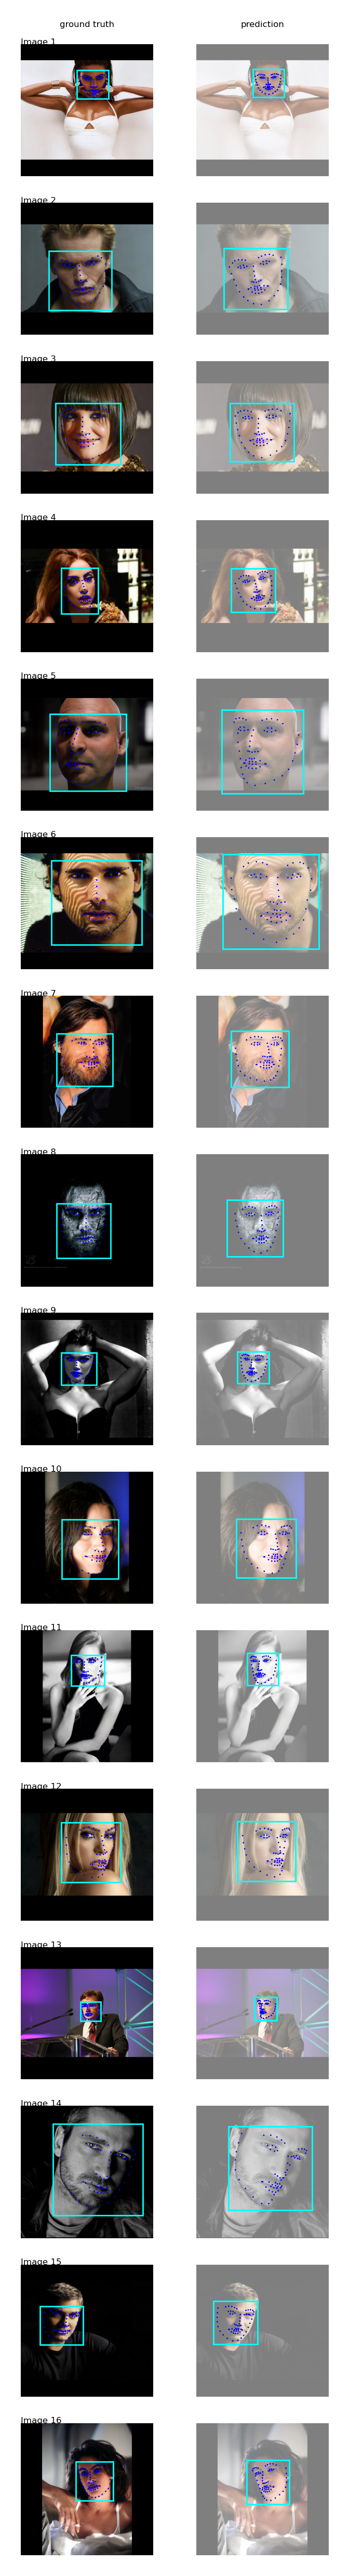

In [18]:
fig, ax = plt.subplots(16,2,dpi = 400, figsize=(2,16))
for i in range(16):
    sample = test_set[i]
    img, annot = sample['img'], sample['annot']
    img = img.int()
    box, ldmk = annot[0][:4], annot[0][4:]
    ldmk = ldmk.reshape(-1,2)
    if picked_boxes[i] is not None:
        box_p, ldmk_p = picked_boxes[i][0].cpu(), picked_landmarks[i].cpu()
    else:
        box_p, ldmk_p = [], []
    
    ax[i,0].imshow(img)
    ax[i,0].text(0, 0, 'Image '+str(i+1),fontsize=3)
    ax[i,0].add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, edgecolor='cyan',linewidth=0.5))
    ax[i,0].scatter(ldmk[:,0],ldmk[:,1], c='b',s=1, marker='.', edgecolors='none')
    
    ax[i,1].imshow(img, alpha=0.5)
    for b in box_p:
        ax[i,1].add_patch(plt.Rectangle((box_p[0], box_p[1]), box_p[2]-box_p[0], box_p[3]-box_p[1], fill=False, edgecolor='cyan',linewidth=0.5)) 
    for l in ldmk_p:
        l = l.reshape(-1,2)
        ax[i,1].scatter(l[:,0],l[:,1], c='b',s=1, marker='.', edgecolors='none')

for axes in ax.ravel():
    axes.axis('off')
ax[0][0].set_title("ground truth",fontsize=3)
ax[0][1].set_title("prediction",fontsize=3)
fig.show()